<a href="https://colab.research.google.com/github/IMOKURI/signate-471/blob/main/%E5%8C%BB%E5%AD%A6%E8%AB%96%E6%96%87%E3%81%AE%E8%87%AA%E5%8B%95%E4%BB%95%E5%88%86%E3%81%91%E3%83%81%E3%83%A3%E3%83%AC%E3%83%B3%E3%82%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook ...

competition site: https://signate.jp/competitions/471







## ToDo

- [ ] pre train のモデルの save と load
- [ ] preprocess したデータの save と load (wandb)

### Idea

- [x] [ラベル判定結果の誤りに関するお知らせ](https://signate.jp/competitions/471/discussions/20210816152356-59) をとりこむ 
- [ ] 分類で推論、回帰で推論
- [x] 回帰の場合の境界値の最適化
    - [ ] second stage で学習べきかも
        - [ ] heamy という stacking のライブラリがある
        - [ ] CNN で stacking がいいかもしれない https://tawara.hatenablog.com/entry/2020/12/16/132415
            - 縦・横、チャネル数が、クラス数（１）・モデル数（ｎ）・１で、 1xn で畳み込む 
    - [ ] Nelder-Mead 法 という最適化手法を調べる
- [ ] 最適な境界値はモデルによって異なるので、アンサンブルの時は、 vote ensemble がいいかもしれない
- [x] アブストで事前学習して、タイトルでメイン学習 https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain
    - 事前学習は、Masked LM
- [x] タイトルだけで学習・推論
- [ ] タイトル + アブストで学習・推論
    - [ ] タイトルだけで推論したのとアンサンブルができる
    - [ ] Longformer がいいかもしれない `allenai/longformer-base-4096`
    - [ ] large モデルためす
- [ ] アブスト + タイトル で学習・推論
- [ ] アブストが空 or not でモデルわける
- [ ] アブストの max length 調整
    - [ ] 途中で切る。デフォルトの 512 はありそう。ほとんどのアブストがその長さで収まる
    - [ ] 要約する方法があるかなぁ
- [x] dropout を 0 にする
- [x] gradient cripping を 0.2 or 0.5 で試す
- [ ] re-initialization
    - This paper (https://arxiv.org/pdf/2006.05987.pdf) shows that fine-tuning with reinitialization last N layers works well.
    - Different models have different optimal N. Almost models set N=4~5, gpt2-models set N=6.
    - https://github.com/kurupical/commonlit/blob/8781139c8ed4cc59f7c7ac9d97c72c351ee91377/exp/exp502.py#L497
- [ ] Pre trained なレイヤーのfreeze https://raphaelb.org/posts/freezing-bert/
- [ ] Recall を伸ばすための loss function は考えられるか。 https://openreview.net/pdf?id=SlprFTIQP3
    - [x] f1 score を微分可能にして、 loss 関数に使うアプローチ https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354 https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
    - [ ] epoch ごとに beta の値を増やしていく epoch * 2 とか
- [ ] 出現する単語のクラスタリング
- [x] TF-IDF して、 リッジ回帰 → ベースライン2 でやった
    - IF-IDF の結果もBERTの特徴量にできないだろうか
    - https://www.kaggle.com/semyonkoshkarov/tf-idf-linearsvr-baseline も参考になるかも
- [ ] 医療用語で事前学習されたモデルを使ってみる
    - [x] BioBERT https://github.com/dmis-lab/biobert `dmis-lab/biobert-base-cased-v1.1` 286k downloads
        - [ ] large モデル試す
    - [ ] Med-BERT https://github.com/ZhiGroup/Med-BERT
        - 診断精度に貢献しているかもしれない(いや、一般的な話だったｗ) https://www.nature.com/articles/s41746-021-00455-y
    - [x] `microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext` 30.8k downloads https://www.axion.zone/microsoft-researchers-claim-state-of-the-art-biomedical-nlp-model/
    - [x] `bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12` 4.3k downloads https://github.com/ncbi-nlp/bluebert
        - [ ] large モデル試す
    - [x] `emilyalsentzer/Bio_ClinicalBERT` https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT
    - [ ] `emilyalsentzer/Bio_Discharge_Summary_BERT` https://huggingface.co/emilyalsentzer/Bio_Discharge_Summary_BERT
    - [x] `lordtt13/COVID-SciBERT` https://huggingface.co/lordtt13/COVID-SciBERT
    - [ ] `allenai/scibert_scivocab_uncased` https://huggingface.co/allenai/scibert_scivocab_uncased
- [ ] Augmentation https://neptune.ai/blog/data-augmentation-nlp
    - [ ] Back translation: 他言語に翻訳して、もう一回翻訳する（英語→フランス語→英語） https://qiita.com/nena0undefined/items/c2926bad07039e5540ab
    - [ ] Synonym Replacement: 単語のいくつかを、同じ意味の別の単語に置き換える
        - [ ] 自然言語の augmentation ができるライブラリ https://github.com/makcedward/nlpaug
- [ ] TTA
- [ ] ベースラインのシンプルさを取り戻す。(思ったよりベースラインのスコアが良かったので、それを取り込む・・・）
    - [ ] weight decay を調整 0.01 or 0


### Experiments

- BERT でアブストの　pre train をしてもスコアは上がっていない（学習の方法を工夫した方がよいかも）
- BERT Large は title の学習には大きすぎて？ loss が Base モデルに及ばない。
- epoch 3 で val loss が下がらないので、 epoch 3 で aug かけるとかありかもしれない
- `dmis-lab/biobert-base-cased-v1.1` と `bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12` の成績がよい


## Prepare for Colab

In [1]:
!nvidia-smi

Thu Sep  2 11:30:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/gdrive')

        !cp /gdrive/MyDrive/Datasets/signate-471/train.csv .
        !cp /gdrive/MyDrive/Datasets/signate-471/test.csv .
        !cp /gdrive/MyDrive/Datasets/signate-471/sample_submit.csv .

    # for StratifiedGroupKFold
    # !pip uninstall -y scikit-learn
    # !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

    # for MultilabelStratifiedKFold
    !pip install -q iterative-stratification

    # !pip install -qU 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

    !pip install -q wandb
    !pip install -q transformers
    !pip install -q textstat

    !touch init.txt

Already initialized.


In [3]:
# Install_LightGBM_with_GPU

if os.path.exists('init_lightgbm.txt'):
    print("Already initialized.")

else:
    ! git clone --recursive https://github.com/Microsoft/LightGBM

    %cd /content/LightGBM
    ! mkdir -p build

    %cd build
    ! cmake -DUSE_GPU=1 /content/LightGBM
    ! make -j$(nproc)
    ! sudo apt-get -y install python-pip
    ! sudo -H pip install setuptools pandas==1.3.0 numpy scipy scikit-learn -U

    %cd /content/LightGBM/python-package
    ! sudo python setup.py install --precompile

    %cd /content/

    !touch init_lightgbm.txt

Already initialized.


## Library

In [4]:
import glob
import json
import math
import os
import random
import re
import time
import warnings
from contextlib import contextmanager

import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import textstat
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers as T
import wandb
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error, fbeta_score
from sklearn.model_selection import KFold, StratifiedKFold  # , StratifiedGroupKFold
from torch.optim import SGD, Adam  # , AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm


In [5]:
warnings.filterwarnings("ignore")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
netrc = "../input/wandbtoken/.netrc"

if 'google.colab' in sys.modules:
    netrc = "/gdrive/MyDrive/.netrc"

!cp -f {netrc} ~/

!wandb login

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [9]:
wandb_job_type = ""
wandb_notes = ""
wandb_tags = []

## Load Data

In [10]:
DATA_DIR = "../input/signate-471/"
OUTPUT_DIR = "./"

if 'google.colab' in sys.modules:
    DATA_DIR = "./"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [11]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

## Config

In [12]:
class Config:
    wandb_entity = "ponkots"
    wandb_project = "signate-471"
    print_freq = 100

    pre_train = False
    train = False
    validate = False
    inference = False
    stack = True

    debug = False
    multi_gpu = False
    apex = False


In [13]:
if Config.pre_train:
    wandb_job_type = "pre_training"

elif Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

elif Config.stack:
    wandb_job_type = "stacking"

In [14]:
if Config.apex:
    from apex import amp

In [15]:
# seed = random.randrange(10000)
seed = 440

print(seed)

440


In [16]:
config_defaults = {
    "seed": seed,
    "input": "title_abstract",  # "abstract_title",  # "preprocessed_title_abstract",  # "title", # "title_abstract",
    "max_len": 512,
    "border": "minimize", # "fixed", "minimize",
    "n_class": 1,
    "n_fold": 5,
    "gradient_accumulation_steps": 2,
    "max_grad_norm": 1000,
    "num_workers": 4,
    "batch_size": 12,
    "epochs": 3,
    "optimizer": "BertAdamW",
    "scheduler": "get_cosine_schedule_with_warmup",
    "criterion": "BCEWithLogitsLoss",  # "FBetaLoss",  # "BCEWithLogitsLoss",
    "lr": 2e-5,
    "min_lr": 1e-5,
    "weight_decay": 0.01,
    "dropout": 0.1,
    "model_name": "",
    "reinit_layers": 0,
    "freeze_layers": 0,
    "best": "loss",  # "score",
    "inference_runs": [
        "1uv8m7j0", # 56
        "x2rmxctu", # 59
        "258um1kf", # 60
    ],
}

In [17]:
if Config.stack:
    config_stack = {
        "objective": "binary",
        "criterion": "binary_logloss",
        "lr": 0.01,
        "max_depth": 7,
        "num_leaves": 31,
        "min_data_in_leaf": 20,
        "dropout": 0.1,
    }
    config_defaults.update(config_stack)

In [18]:
if not (Config.validate or Config.inference or Config.stack):
    config_defaults["inference_runs"] = []

In [19]:
if Config.debug:
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [20]:
if config_defaults["optimizer"] == "BertAdamW":
    config_defaults["lr_69"] = 5e-5
    config_defaults["lr_133"] = 1e-4

In [21]:
# Update by epoch
# num_steps = config_defaults["epochs"]

# Update by batch
num_data = 1000 if Config.debug else len(train)
num_steps = num_data // config_defaults["n_fold"] * (config_defaults["n_fold"] - 1) // config_defaults["batch_size"] // config_defaults["gradient_accumulation_steps"] * config_defaults["epochs"]

print(num_steps)

if config_defaults["scheduler"] == "CosineAnnealingWarmRestarts":
    config_defaults["T_0"] = num_steps

elif config_defaults["scheduler"] == "CosineAnnealingLR":
    config_defaults["T_max"] = num_steps

elif config_defaults["scheduler"] == "ReduceLROnPlateau":
    config_defaults["factor"] = 0.2
    config_defaults["patience"] = 4
    config_defaults["eps"] = 1e-6

elif config_defaults["scheduler"] == "CosineAnnealingWarmupRestarts":
    config_defaults["first_cycle_steps"] = num_steps
    config_defaults["warmup_steps"] = num_steps // 10

elif config_defaults["scheduler"] == "get_cosine_schedule_with_warmup":
    config_defaults["num_training_steps"] = num_steps
    config_defaults["num_warmup_steps"] = max(50, num_steps // 10)

2712


In [22]:
if Config.debug:
    run = wandb.init(entity=Config.wandb_entity, project=Config.wandb_project, config=config_defaults, mode="disabled")
else:
    run = wandb.init(entity=Config.wandb_entity, project=Config.wandb_project, config=config_defaults, notes=wandb_notes, tags=wandb_tags, job_type=wandb_job_type, save_code=True)

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [23]:
config = wandb.config

## EDA-1

In [24]:
# アブストが空っぽのが結構ある
print(train.isnull().sum())
print(test.isnull().sum())

id              0
title           0
abstract     4390
judgement       0
dtype: int64
id             0
title          0
abstract    6546
dtype: int64


## Preprocessing

In [25]:
def preprocess(data):
    
    title_abstract = []
    for e in data:

        # アルファベット以外は空白に置換します。
        e = re.sub("[^a-zA-Z]", " ", e)

        # 小文字に変換します。
        e = e.lower()

        # token に分割します。
        e = nltk.word_tokenize(e)

        # stop word を削除します。
        e = [word for word in e if not word in set(nltk.corpus.stopwords.words("english"))]

        # 見出し語化します。
        lemma = nltk.WordNetLemmatizer()
        e = [lemma.lemmatize(word) for word in e]
        e = " ".join(e)

        title_abstract.append(e)

    return title_abstract

In [26]:
def get_train_data(train):

    # NaN を空白で埋めます。
    train = train.fillna("")

    # abstract の有無を Stratified KFold で使います。
    train["nan_abstract"] = np.where(train["abstract"] == "", 1, 0)

    # title の単語数
    train["len_title"] = train["title"].apply(lambda x: len(x.split()))

    # abstract の単語数
    train["len_abstract"] = train["abstract"].apply(lambda x: len(x.split()))

    # title と abstract を接続します。
    train["title_abstract"] = train[["title", "abstract"]].agg(" ".join, axis=1)
    train["abstract_title"] = train[["abstract", "title"]].agg(" ".join, axis=1)

    # train["preprocessed_title_abstract"] = preprocess(train["title_abstract"])

    # 前処理した文の単語数
    # train["len_preprocessed_title_abstract"] = train["preprocessed_title_abstract"].apply(lambda x: len(x.split()))

    return train

In [27]:
def get_test_data(test):

    # NaN を空白で埋めます。
    test = test.fillna("")

    # title の単語数
    test["len_title"] = test["title"].apply(lambda x: len(x.split()))

    # abstract の単語数
    test["len_abstract"] = test["abstract"].apply(lambda x: len(x.split()))

    # title と abstract を接続します。
    test["title_abstract"] = test[["title", "abstract"]].agg(" ".join, axis=1)
    test["abstract_title"] = test[["abstract", "title"]].agg(" ".join, axis=1)

    # test["preprocessed_title_abstract"] = preprocess(test["title_abstract"])

    # 前処理した文の単語数
    # test["len_preprocessed_title_abstract"] = test["preprocessed_title_abstract"].apply(lambda x: len(x.split()))

    return test

In [28]:
if False:  # os.path.exists("/gdrive/MyDrive/Datasets/signate-471/preprocessed_train.csv"):
    !cp -f /gdrive/MyDrive/Datasets/signate-471/preprocessed_train.csv .
    train = pd.read_csv("preprocessed_train.csv")

    # csv を再読み込みすると NaN に戻ってしまうので、再度変換します。
    train = train.fillna("")

else:
    # 一度、前処理したものは保存しておきます。
    train = get_train_data(train)
    # train.to_csv("preprocessed_train.csv")

    # artifact = wandb.Artifact('preprocessed_train', type='dataset')
    # artifact.add_file("preprocessed_train.csv")
    # run.log_artifact(artifact)

    # !cp -f preprocessed_train.csv /gdrive/MyDrive/Datasets/signate-471/

In [29]:
if False:  # os.path.exists("/gdrive/MyDrive/Datasets/signate-471/preprocessed_test.csv"):
    !cp -f /gdrive/MyDrive/Datasets/signate-471/preprocessed_test.csv .
    test = pd.read_csv("preprocessed_test.csv")

    # csv を再読み込みすると NaN に戻ってしまうので、再度変換します。
    test = test.fillna("")

else:
    # 一度、前処理したものは保存しておきます。
    test = get_test_data(test)
    # test.to_csv("preprocessed_test.csv")

    # artifact = wandb.Artifact('preprocessed_test', type='dataset')
    # artifact.add_file("preprocessed_test.csv")
    # run.log_artifact(artifact)

    # !cp -f preprocessed_test.csv /gdrive/MyDrive/Datasets/signate-471/

## EDA-2

In [30]:
# abstract に改行は含まれていない
print(len(train[train["abstract"].str.contains("\n")]))
print(len(test[test["abstract"].str.contains("\n")]))

0
0


In [31]:
# title の単語数
print(train["len_title"].max())
print(test["len_title"].max())

53
69


In [32]:
# abstract の単語数
print(train["len_abstract"].max())
print(test["len_abstract"].max())

1535
1445


In [33]:
# 前処理した文の単語数
# print(train["len_preprocessed_title_abstract"].max())
# print(test["len_preprocessed_title_abstract"].max())

In [34]:
for ds in [train, test, sub]:
    print(f"=" * 80)
    ds.info()
    display(ds.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27145 entries, 0 to 27144
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              27145 non-null  int64 
 1   title           27145 non-null  object
 2   abstract        27145 non-null  object
 3   judgement       27145 non-null  int64 
 4   nan_abstract    27145 non-null  int64 
 5   len_title       27145 non-null  int64 
 6   len_abstract    27145 non-null  int64 
 7   title_abstract  27145 non-null  object
 8   abstract_title  27145 non-null  object
dtypes: int64(5), object(4)
memory usage: 1.9+ MB


,id,title,abstract,judgement,nan_abstract,len_title,len_abstract,title_abstract,abstract_title
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,0,10,193,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,0,23,214,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,0,10,133,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,13,374,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,,0,1,16,0,Prolonged shedding of SARS-CoV-2 in an elderly...,Prolonged shedding of SARS-CoV-2 in an elderl...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40834 entries, 0 to 40833
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              40834 non-null  int64 
 1   title           40834 non-null  object
 2   abstract        40834 non-null  object
 3   len_title       40834 non-null  int64 
 4   len_abstract    40834 non-null  int64 
 5   title_abstract  40834 non-null  object
 6   abstract_title  40834 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.2+ MB


,id,title,abstract,len_title,len_abstract,title_abstract,abstract_title
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...,16,245,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...
1,27146,Leukoerythroblastic reaction in a patient with...,,8,0,Leukoerythroblastic reaction in a patient with...,Leukoerythroblastic reaction in a patient wit...
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...,14,315,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...,11,119,Adaptive image segmentation for robust measure...,We present a method that significantly improve...
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...,13,224,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40834 entries, 0 to 40833
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         40834 non-null  int64
 1   judgement  40834 non-null  int64
dtypes: int64(2)
memory usage: 638.2 KB


,id,judgement
0,27145,0
1,27146,1
2,27147,1
3,27148,0
4,27149,1


### 目的変数 judgement の分布

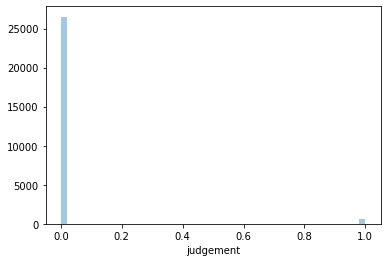

In [35]:
sns.distplot(train["judgement"], kde=False)

In [36]:
train["judgement"].value_counts()

0    26515
1      630
Name: judgement, dtype: int64

In [37]:
border = len(train[train["judgement"] == 1]) / len(train["judgement"])
print(border)

0.0232086940504697


### title の単語数の分布

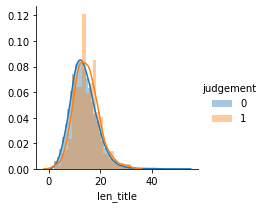

In [38]:
g = sns.FacetGrid(train[["judgement", "len_title"]], hue='judgement')
g.map(sns.distplot, 'len_title', label='judgement', hist=True, rug=False)
g.add_legend()

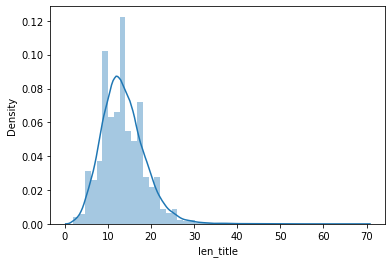

In [39]:
sns.distplot(test["len_title"], hist=True, rug=False)

### abstract の単語数の分布

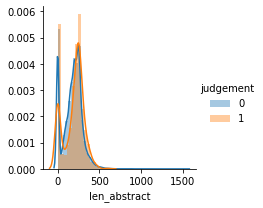

In [40]:
g = sns.FacetGrid(train[["judgement", "len_abstract"]], hue='judgement')
g.map(sns.distplot, 'len_abstract', label='judgement', hist=True, rug=False)
g.add_legend()

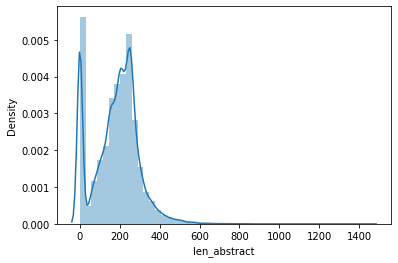

In [41]:
sns.distplot(test["len_abstract"], hist=True, rug=False)

## Load Models

In [42]:
if Config.validate:
    api = wandb.Api()

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            run.file("oof_df.csv").download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["id", "preds"]]
        oof.columns = ["id", f"preds{n}"]
        train = pd.merge(train, oof, on="id")
    
    print(train.columns)

In [43]:
if Config.inference:
    api = wandb.Api()
    inference_models = []

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        inference_model = {}
        inference_model["run_id"] = run_id
        inference_model["model_name"] = run.config["model_name"]

        for fold in range(config.n_fold):
            try:
                run.file(f"{inference_model['model_name'].replace('/', '-')}_fold{fold}_best.pth").download(run_id)
            except wandb.CommError:
                # Already downloaded.
                pass

            model_preds = torch.load(f"{run_id}/{inference_model['model_name'].replace('/', '-')}_fold{fold}_best.pth")
            inference_model[f"state_fold{fold}"] = model_preds["model"]
            inference_model[f"preds_fold{fold}"] = model_preds["preds"]

        inference_models.append(inference_model)
    
    print({m['run_id']: m['model_name'] for m in inference_models})

In [44]:
if Config.stack:
    api = wandb.Api()

    feat_id = 0
    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            run.file("validation_df.csv").download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        try:
            run.file("prediction_df.csv").download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        val = pd.read_csv(f"{run_id}/validation_df.csv")
        pred = pd.read_csv(f"{run_id}/prediction_df.csv")

        cols = [c for c in val.columns if c.startswith("preds")]
        val = val[["id"] + cols]
        pred = pred[["id"] + cols]

        adjust_cols = ["id"] + [f"preds{n}" for n in range(feat_id, feat_id + len(cols))]
        val.columns = adjust_cols
        pred.columns = adjust_cols

        feat_id += len(cols)

        train = pd.merge(train, val, on="id")
        test = pd.merge(test, pred, on="id")
    
    print(f"train: {train.columns}")
    print(f"test: {test.columns}")

train: Index(['id', 'title', 'abstract', 'judgement', 'nan_abstract', 'len_title',
       'len_abstract', 'title_abstract', 'abstract_title', 'preds0', 'preds1',
       'preds2', 'preds3', 'preds4', 'preds5', 'preds6', 'preds7', 'preds8'],
      dtype='object')
test: Index(['id', 'title', 'abstract', 'len_title', 'len_abstract',
       'title_abstract', 'abstract_title', 'preds0', 'preds1', 'preds2',
       'preds3', 'preds4', 'preds5', 'preds6', 'preds7', 'preds8'],
      dtype='object')


In [45]:
if Config.debug and not Config.stack:
    train = train.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    test = test.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    sub = sub.sample(n=1000, random_state=config.seed).reset_index(drop=True)

## CV Split

In [46]:
Fold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[["judgement", "nan_abstract"]])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.uint8)
print(train.groupby(["fold", "judgement", "nan_abstract"]).size())

fold  judgement  nan_abstract
0     0          0               4446
                 1                857
      1          0                105
                 1                 21
1     0          0               4448
                 1                855
      1          0                103
                 1                 23
2     0          0               4448
                 1                855
      1          0                103
                 1                 23
3     0          0               4448
                 1                855
      1          0                103
                 1                 23
4     0          0               4455
                 1                848
      1          0                 96
                 1                 30
dtype: int64


## Utils

In [47]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)


## Dataset

In [48]:
class BaseDataset(Dataset):
    def __init__(self, df, model_name, include_labels=True):
        tokenizer = T.AutoTokenizer.from_pretrained(model_name)

        self.df = df
        self.include_labels = include_labels

        self.title = df[config.input].tolist()
        self.encoded = tokenizer.batch_encode_plus(
            self.title,
            padding = 'max_length',            
            max_length = config.max_len,
            truncation = True,
            return_attention_mask=True
        )
        
        if self.include_labels:
            self.labels = df["judgement"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encoded['input_ids'][idx])
        attention_mask = torch.tensor(self.encoded['attention_mask'][idx])

        if self.include_labels:
            label = torch.tensor(self.labels[idx]).float()
            return input_ids, attention_mask, label

        return input_ids, attention_mask


In [49]:
# Test

if config.model_name != "":

    train_ds = BaseDataset(train, config.model_name)

    for i in range(1):
        input_ids, attention_mask, label = train_ds[i]
        print(input_ids)
        print(attention_mask)
        print(f"label: {label}")


## Model

### BaseModel

In [50]:
if config.model_name != "":
    print(T.AutoConfig.from_pretrained(config.model_name))

In [51]:
class BaseModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        if "base" in model_name or "L-12" in model_name or "COVID-SciBERT" in model_name:
            out_dim = 768
        elif "large" in model_name or "L-24" in model_name:
            out_dim = 1024

        auto_config = T.AutoConfig.from_pretrained(model_name)
        auto_config.update({
            "output_hidden_states": True,
            "hidden_dropout_prob": config.dropout,
            # "layer_norm_eps": 1e-7,
        })
        
        self.auto_model = T.AutoModel.from_pretrained(model_name, config=auto_config)  

        self.attention = nn.Sequential(
            nn.Linear(out_dim, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(
            nn.Linear(out_dim, 1)                        
        )

        if config.reinit_layers > 0:
            self.re_init()

        if config.freeze_layers > 0:
            self.freeze()

    def forward(self, input_ids, attention_mask):
        bert_output = self.auto_model(input_ids=input_ids, attention_mask=attention_mask)        

        # There are a total of 13 layers of hidden states.
        # 1 for the embedding layer, and 12 for the 12 Roberta layers.
        # We take the hidden states from the last Roberta layer.
        last_layer_hidden_states = bert_output.hidden_states[-1]

        # The number of cells is config.max_len.
        # The size of the hidden state of each cell is 768 (for roberta-base).
        # In order to condense hidden states of all cells to a context vector,
        # we compute a weighted average of the hidden states of all cells.
        # We compute the weight of each cell, using the attention neural network.
        weights = self.attention(last_layer_hidden_states)
                
        # weights.shape is config.batch_size x config.max_len x 1
        # last_layer_hidden_states.shape is config.batch_size x config.max_len x 768        
        # Now we compute context_vector as the weighted average.
        # context_vector.shape is config.batch_size x 768
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        
        # Now we reduce the context vector to the prediction score.
        out = self.regressor(context_vector).squeeze()

        return out

    def re_init(self):
        # re-init pooler
        self.auto_model.pooler.dense.weight.data.normal_(mean=0.0, std=self.auto_model.config.initializer_range)
        self.auto_model.pooler.dense.bias.data.zero_()
        for p in self.auto_model.pooler.parameters():
            p.requires_grad = True

        # re-init encoder
        layers = self.auto_model.encoder.layer[-config.reinit_layers:]
        for layer in layers:
            for module in layer.modules():
                if isinstance(module, nn.Linear):
                    # Slightly different from the TF version which uses truncated_normal for initialization
                    # cf https://github.com/pytorch/pytorch/pull/5617
                    module.weight.data.normal_(mean=0.0, std=self.auto_model.config.initializer_range)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.Embedding):
                    module.weight.data.normal_(mean=0.0, std=self.auto_model.config.initializer_range)
                    if module.padding_idx is not None:
                        module.weight.data[module.padding_idx].zero_()
                elif isinstance(module, nn.LayerNorm):
                    module.bias.data.zero_()
                    module.weight.data.fill_(1.0)

    def freeze(self):
        # freeze embedding
        for param in self.auto_model.embeddings.parameters():
            param.requires_grad = False

        # freeze encoder
        layers = self.auto_model.encoder.layer[:config.freeze_layers]
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = False

In [52]:
# Test

if config.model_name != "":

    model = BaseModel(config.model_name)
    print(model)

    train_dataset = BaseDataset(train, config.model_name)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for input_ids, attention_mask, labels in train_loader:
        output = model(input_ids, attention_mask)
        print(output)
        break


In [53]:
# Test

if config.model_name != "":
    for n, (name, tensor) in enumerate(list(model.named_parameters())):
        print(f"{n:>4}: {tensor.requires_grad}, {name}")

### StackingModel

## Optimizer

In [54]:
def bert_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    if "albert-base" in config.model_name:
        bert_parameters = named_parameters[:23]    
        attention_parameters = named_parameters[25:29]
        regressor_parameters = named_parameters[29:]
        second_block = 999
        third_block = 999

    elif "base" in config.model_name or "L-12" in config.model_name or "COVID-SciBERT" in config.model_name:
        bert_parameters = named_parameters[:197]    
        attention_parameters = named_parameters[199:203]
        regressor_parameters = named_parameters[203:]
        second_block = 69
        third_block = 133

    elif "large" in config.model_name or "L-24" in config.model_name:
        bert_parameters = named_parameters[:388]    
        attention_parameters = named_parameters[391:395]
        regressor_parameters = named_parameters[395:]
        second_block = 133
        third_block = 261
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})

    for layer_num, (name, params) in enumerate(bert_parameters):
        weight_decay = 0.0 if "bias" in name else config.weight_decay

        lr = config.lr

        if layer_num >= second_block:        
            lr = config.lr_69

        if layer_num >= third_block:
            lr = config.lr_133

        parameters.append({"params": params, "weight_decay": weight_decay, "lr": lr})

    return T.AdamW(parameters)


## Loss

In [55]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

In [56]:
# https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
class FBetaLoss(nn.Module):

    def __init__(self, beta=1.0, epsilon=1e-7):
        super().__init__()
        self.beta = beta
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true):
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        beta_squared = self.beta ** 2
        fbeta = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + self.epsilon)
        fbeta = fbeta.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - fbeta.mean()

## Scoring

In [57]:
def get_score(y_true, y_pred, b=border):
    y_pred = np.where(y_pred < b, 0, 1)
    return fbeta_score(y_true, y_pred, beta=7.0)

In [58]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    # wandb.log({"fold": fold, "CV": score})
    if fold == config.n_fold:
        wandb.run.summary[f"CV"] = score
    else:
        wandb.run.summary[f"CV_fold{fold}"] = score


In [59]:
def determine_border(b, y_true, y_pred):
    return -1 * get_score(y_true, y_pred, b)


## Helper functions

In [60]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [61]:
def pre_train_fn():
    tokenizer = T.AutoTokenizer.from_pretrained(config.model_name)
    model = T.AutoModelForMaskedLM.from_pretrained(config.model_name)

    tokenizer.save_pretrained(f"./pretrained_{config.model_name}")

    train_dataset = T.LineByLineTextDataset(tokenizer=tokenizer, file_path="abstracts.txt", block_size=512)
    valid_dataset = T.LineByLineTextDataset(tokenizer=tokenizer, file_path="abstracts.txt", block_size=512)

    data_collator = T.DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=True, mlm_probability=0.15
    )

    training_args = T.TrainingArguments(
        output_dir = f"./pretrained_{config.model_name}_chk",
        overwrite_output_dir = True,
        num_train_epochs = 5,
        per_device_train_batch_size = 4,
        per_device_eval_batch_size = 4,
        gradient_accumulation_steps = 4,
        evaluation_strategy = 'steps',
        save_total_limit = 2,
        eval_steps = 105,
        save_steps = 105,
        metric_for_best_model = 'eval_loss',
        greater_is_better = False,
        load_best_model_at_end = True,
        prediction_loss_only = True,
        report_to = "wandb",
    )

    trainer = T.Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
    )

    trainer.train()

    trainer.save_model(f"./pretrained_{config.model_name}")

In [62]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    optimizer.zero_grad()

    for step, (input_ids, attention_mask, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        y_preds = model(input_ids, attention_mask)

        loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps
        if Config.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()
            
            global_step += 1

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                # f"LR: {scheduler.get_last_lr()[0]:.6f}  "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [63]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()

    for step, (input_ids, attention_mask, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # compute loss
        with torch.no_grad():
            y_preds = model(input_ids, attention_mask)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # record score
        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [64]:
def inference():
    predictions = sub.copy()

    for n, model_item in enumerate(inference_models):
        test_dataset = BaseDataset(test, model_item['model_name'], include_labels=False)
        test_loader = DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
        )

        preds = []
        for fold in range(config.n_fold):
            LOGGER.info(f"========== ID: {model_item['run_id']} model: {model_item['model_name']} fold: {fold} inference ==========")
            model = BaseModel(model_item['model_name'])
            model.to(device)
            model.load_state_dict(model_item[f"state_fold{fold}"])
            model.eval()
            fold_preds = []
            for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                with torch.no_grad():
                    y_preds = model(input_ids, attention_mask)
                # avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
                fold_preds.append(y_preds.to("cpu").numpy())
            preds.append(np.concatenate(fold_preds))

        preds = np.mean(preds, axis=0)

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        predictions[f"preds{n}"] = preds

    return predictions

In [65]:
def stacking_inference():
    feature_cols = [col for col in test.columns if col.startswith("preds")]
    predictions = sub.copy()

    preds = []
    for fold in range(config.n_fold):
        LOGGER.info(f"========== fold: {fold} inference ==========")
        bst = lgb.Booster(model_file=OUTPUT_DIR + f"lgb_fold{fold}_best.txt")
        fold_preds = bst.predict(test[feature_cols])
        preds.append(fold_preds)

    preds = np.mean(preds, axis=0)
    predictions[f"preds"] = preds

    return predictions

## Train loop

In [66]:
def train_loop(df, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, config.model_name)
    valid_dataset = BaseDataset(valid_folds, config.model_name)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, amsgrad=False)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "BertAdamW":
            optimizer = bert_optimizer(model)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if config.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=config.factor, patience=config.patience, verbose=True, eps=config.eps
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer, first_cycle_steps=config.first_cycle_steps, max_lr=config.lr, min_lr=config.min_lr, warmup_steps=config.warmup_steps
            )
        elif config.scheduler == "get_cosine_schedule_with_warmup":
            scheduler = T.get_cosine_schedule_with_warmup(
                optimizer,
                num_training_steps=config.num_training_steps, 
                num_warmup_steps=config.num_warmup_steps
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not Config.apex and Config.multi_gpu:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # Apex
    # ====================================================
    if Config.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        elif config.criterion == "RMSELoss":
            criterion = RMSELoss()
        elif config.criterion == "FBetaLoss":
            criterion = FBetaLoss(7.0)

        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf

    # if not Config.multi_gpu:
    #     wandb.watch(model, log_freq=Config.print_freq)

    for epoch in range(config.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["judgement"].values

        # if isinstance(scheduler, ReduceLROnPlateau):
        #     scheduler.step(avg_val_loss)
        # else:
        #     scheduler.step()

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/val_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        if (
            (config.best == "score" and score > best_score)
            or (config.best == "loss" and avg_val_loss < best_loss)
        ):
            best_score = score
            best_loss = avg_val_loss

            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model (Loss: {best_loss:.4f})")
            wandb.run.summary[f"loss_fold{fold}"] = score

            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth"
            )
            wandb.save(OUTPUT_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth")

        # if epoch == config.epochs - 1:
        #     LOGGER.info(f"Epoch {epoch+1} - Save final model")
        #     torch.save(
        #         {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_final.pth"
        #     )

    check_point = torch.load(OUTPUT_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"]  # .argmax(1)

    return valid_folds

## Stack loop

In [67]:
def stack_loop(df, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")
    start_time = time.time()

    # ====================================================
    # Dataset
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    feature_cols = [col for col in df.columns if col.startswith("preds")]
    label_cols = ["judgement"]

    train_dataset = lgb.Dataset(data=train_folds[feature_cols], label=train_folds[label_cols], free_raw_data=False)
    valid_dataset = lgb.Dataset(data=valid_folds[feature_cols], label=valid_folds[label_cols], free_raw_data=False)

    # ====================================================
    # Parameters
    # ====================================================

    lgb_params = {
        "objective": config.objective,
        "metric": config.criterion,
        "learning_rate": config.lr,
        "max_depth": config.max_depth,
        "num_leaves": config.num_leaves,
        "min_data_in_leaf": config.min_data_in_leaf,
        "drop_rate": config.dropout,
        "device_type": "gpu" if torch.cuda.is_available() else "cpu",
        "seed": seed + fold,
    }

    # ====================================================
    # Loop
    # ====================================================
    evaluation_results = {}

    clf = lgb.train(
        params=lgb_params,
        train_set=train_dataset,
        num_boost_round=10000,
        valid_sets=[train_dataset, valid_dataset], 
        valid_names=['train', 'eval'],
        early_stopping_rounds=100,
        evals_result=evaluation_results,
        verbose_eval=100,
    )

    importances = pd.DataFrame({
        'features': clf.feature_name(),
        'importance': clf.feature_importance()
    }).sort_values('importance', ascending=False)

    preds = clf.predict(valid_folds[feature_cols], num_iteration=clf.best_iteration)
    valid_labels = valid_folds["judgement"].values

    # scoring
    # score = get_score(valid_labels, preds.argmax(1))
    score = get_score(valid_labels, preds)

    elapsed = time.time() - start_time

    LOGGER.info(f"Result {fold} - Score: {score}, time: {elapsed:.0f}s")

    LOGGER.info(f"Result {fold} - Save Best Model")
    # wandb.run.summary[f"loss_fold{fold}"] = score

    clf.save_model(OUTPUT_DIR + f"lgb_fold{fold}_best.txt", clf.best_iteration)
    wandb.save(OUTPUT_DIR + f"lgb_fold{fold}_best.txt")

    #valid_folds[[str(c) for c in range(config.n_class)]] = preds
    valid_folds["preds"] = preds  # .argmax(1)

    return valid_folds

## Main


In [68]:
def main():
    if Config.pre_train:
        abstract_df = pd.concat([train["abstract"], test["abstract"]])
        abstracts  = '\n'.join(abstract_df.tolist())
        with open("abstracts.txt", "w") as f:
            f.write(abstracts)

        pre_train_fn()

    if Config.train:
        oof_df = pd.DataFrame()
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

    if Config.validate:
        probs = []
        for n in range(len(config.inference_runs)):
            probs.append(train[f"preds{n}"].values)
        preds = np.mean(probs, axis=0)
        train["predictions"] = preds

        # Post process
        if config.border == "minimize":
            res = sp.optimize.minimize_scalar(determine_border, method='bounded', bounds=(0, 1), args=(train["judgement"].values, preds))
            LOGGER.info(f"========== Border Optimization ==========")
            LOGGER.info(f"Border: {res.x:<.5f}, Score: {-res.fun:<.5f}")
            wandb.run.summary[f"CV"] = -res.fun

        elif config.border == "fixed":
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(train)

        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    if Config.inference:
        prediction_df = inference()

        probs = []
        for n in range(len(config.inference_runs)):
            probs.append(prediction_df[f"preds{n}"].values)
        preds = np.mean(probs, axis=0)
        prediction_df["predictions"] = preds

        # Post process
        try:
            b = res.x
        except Exception:
            b = border
        wandb.run.summary[f"border"] = b

        predictions = np.where(preds < b, 0, 1)

        # submission
        sub["judgement"] = predictions  # .argmax(1)
        print(sub["judgement"].value_counts())

        sub.to_csv(OUTPUT_DIR + "submission.csv", index=False, header=False)
        wandb.save(OUTPUT_DIR + "submission.csv")

        prediction_df.to_csv(OUTPUT_DIR + "prediction_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "prediction_df.csv")
        
    if Config.stack:
        # Training
        oof_df = pd.DataFrame()
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df = stack_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)

        # CV result
        if config.border == "minimize":
            res = sp.optimize.minimize_scalar(determine_border, method='bounded', bounds=(0, 1), args=(oof_df["judgement"].values, oof_df["preds"].values))
            LOGGER.info(f"========== CV: Border Optimization ==========")
            LOGGER.info(f"Border: {res.x:<.5f}, Score: {-res.fun:<.5f}")
            wandb.run.summary[f"CV"] = -res.fun
            b = res.x

        elif config.border == "fixed":
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            b = border
        
        wandb.run.summary[f"border"] = b

        # save result
        oof_df.to_csv(OUTPUT_DIR + "stacking_oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "stacking_oof_df.csv")

        # Inference
        prediction_df = stacking_inference()

        predictions = np.where(prediction_df["preds"].values < b, 0, 1)

        # submission
        sub["judgement"] = predictions  # .argmax(1)
        print(sub["judgement"].value_counts())

        sub.to_csv(OUTPUT_DIR + "submission.csv", index=False, header=False)
        wandb.save(OUTPUT_DIR + "submission.csv")

        prediction_df.to_csv(OUTPUT_DIR + "stacking_prediction_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "stacking_prediction_df.csv")

In [69]:
if __name__ == "__main__":
    main()


========== fold: 0 training ==========


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 504, number of negative: 21212
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 21716, number of used features: 9
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.25 MB) transferred to GPU in 0.000956 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [

Result 0 - Score: 0.8816314014106102, time: 2s
Result 0 - Save Best Model
========== fold: 0 result ==========
Score: 0.88163
========== fold: 1 training ==========


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 504, number of negative: 21212
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 21716, number of used features: 9
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.25 MB) transferred to GPU in 0.000934 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [

Result 1 - Score: 0.9160305343511449, time: 2s
Result 1 - Save Best Model


[500]	train's binary_logloss: 0.0180781	eval's binary_logloss: 0.035061
Early stopping, best iteration is:
[428]	train's binary_logloss: 0.0186838	eval's binary_logloss: 0.0350036


========== fold: 1 result ==========
Score: 0.91603
========== fold: 2 training ==========


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 504, number of negative: 21212
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 21716, number of used features: 9
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.25 MB) transferred to GPU in 0.000965 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [

Result 2 - Score: 0.9153846153846155, time: 2s
Result 2 - Save Best Model
========== fold: 2 result ==========
Score: 0.91538
========== fold: 3 training ==========


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 504, number of negative: 21212
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 21716, number of used features: 9
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.25 MB) transferred to GPU in 0.001008 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [

Result 3 - Score: 0.9111791730474732, time: 2s
Result 3 - Save Best Model
========== fold: 3 result ==========
Score: 0.91118
========== fold: 4 training ==========


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[491]	train's binary_logloss: 0.0179763	eval's binary_logloss: 0.0348012
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 504, number of negative: 21212
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 21716, number of used features: 9
[LightGBM] [Info] Using GPU Device: Tesla V100-SXM2-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU pr

Result 4 - Score: 0.9038936959208901, time: 2s
Result 4 - Save Best Model
========== fold: 4 result ==========
Score: 0.90389


[400]	train's binary_logloss: 0.0194327	eval's binary_logloss: 0.0378843
Early stopping, best iteration is:
[322]	train's binary_logloss: 0.0207034	eval's binary_logloss: 0.0378553


========== CV: Border Optimization ==========
Border: 0.01843, Score: 0.90695
========== fold: 0 inference ==========
========== fold: 1 inference ==========
========== fold: 2 inference ==========
========== fold: 3 inference ==========
========== fold: 4 inference ==========


0    38244
1     2590
Name: judgement, dtype: int64


In [70]:
wandb.finish()

CV_fold0,0.88163
CV_fold1,0.91603
CV_fold2,0.91538
CV_fold3,0.91118
CV_fold4,0.90389
CV,0.90695
border,0.01843


## Public LB

In [73]:
RUN_PATH = ""
LB_SCORE = None

In [74]:
if LB_SCORE is not None:
    import wandb
    api = wandb.Api()

    run = api.run(RUN_PATH)
    run.summary["LB"] = LB_SCORE
    run.summary.update()